In [1]:
import torch
from torchvision.transforms import v2 as transforms

import lightning as pl
from lightning.pytorch.callbacks.model_summary import summarize
from lightning.pytorch.callbacks import ModelCheckpoint

import numpy as np

from keyrover.datasets import *
from keyrover.ml import get_device
from keyrover import *

device = get_device()
device

2024-11-19 20:04:01.794 Python[11929:573711] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


'mps'

In [115]:
image_paths = get_dataset_paths()
len(image_paths)

4999

In [116]:
mean, std = get_dataset_norm_params(version=3)
mean, std

(array([    0.26772,     0.28418,     0.28728]),
 array([    0.24712,      0.2489,     0.25881]))

In [117]:
train_paths, _, valid_paths = split_train_test_valid(image_paths, 1, 0.1)

SIZE = (256, 256)

train_dataset = KeyboardTexCoordsDataset(train_paths, size=SIZE)
valid_dataset = KeyboardTexCoordsDataset(valid_paths, size=SIZE)

len(train_dataset), len(valid_dataset)

  0%|          | 0/4500 [00:00<?, ?it/s]

2024-11-19 21:01:30.799 Python[12509:607267] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-19 21:01:30.799 Python[12508:607260] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-19 21:01:30.799 Python[12504:607246] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-19 21:01:30.993 Python[12501:607237] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-19 21:01:30.997 Python[12505:607250] WARNING: Secure coding is not enabled for restorable st

  0%|          | 0/499 [00:00<?, ?it/s]

2024-11-19 21:01:45.278 Python[12559:607731] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-19 21:01:45.279 Python[12564:607749] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-19 21:01:45.423 Python[12563:607745] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-19 21:01:45.571 Python[12568:607764] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-19 21:01:45.571 Python[12566:607756] WARNING: Secure coding is not enabled for restorable st

(4500, 499)

In [118]:
train_dataset.set_augmentations([
    transforms.ToDtype(torch.float32, scale=True),
    transforms.GaussianNoise(sigma=0.01),
    transforms.RandomApply([transforms.GaussianNoise(sigma=0.01)], p=0.5),
    transforms.Normalize(mean, std),
])

valid_dataset.set_augmentations([
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std),
])

Mask tensor(-1.) tensor(0.9688) torch.float32 torch.Size([2, 256, 256])
Image tensor(-1.1100) tensor(2.9633)


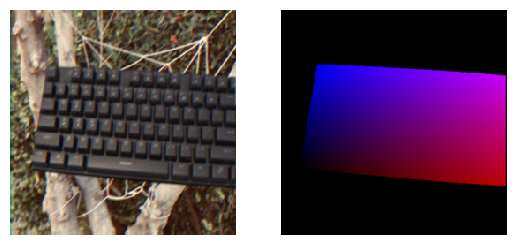

In [119]:
img, mask = train_dataset.random_img()
print("Mask", mask.min(), mask.max(), mask.dtype, mask.shape)
print("Image", img.min(), img.max())
imshow(img, mask)

In [157]:
from torch.utils.data import DataLoader

BATCH_SIZE = 48

dl_kwargs = {"batch_size": BATCH_SIZE, "num_workers": 2, "persistent_workers": True, "pin_memory": False}

train_dataloader = DataLoader(train_dataset, **dl_kwargs, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, **dl_kwargs)

In [261]:
from torchvision import models


class CornersRegressionModel(pl.LightningModule):
    def __init__(self, lr: float | None = None) -> None:
        super().__init__()

        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Freeze the parameters of the pre-trained layers
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze the parameters of the last few layers for fine-tuning
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        self.loss_fn = torch.nn.MSELoss()

        self.model.fc = torch.nn.Linear(self.model.fc.in_features, 6)

        self.learning_rate = lr
        self.lr = self.learning_rate
        self.save_hyperparameters()

    def predict(self, image: torch.Tensor, mask: bool = True) -> np.ndarray:
        image = image.to(self.device)
        if len(image.shape) == 3:
            image = image.unsqueeze(0)

        with torch.no_grad():
            pred = self.forward(image, mask=mask).cpu().numpy()

        if len(pred) == 1:
            return pred[0,]
        return pred

    def forward(self, image: torch.Tensor, mask: bool = True) -> torch.Tensor:
        predictions = self.model(image)
        print(predictions)
        return prediction_to_texture_coordinates(predictions)

    def _step(self, batch: tuple[torch.Tensor, torch.Tensor], stage: str) -> float:
        image, target = batch

        predictions = self.model(image)
        texcoords = prediction_to_texture_coordinates(predictions)

        loss = self.loss_fn(texcoords, target)
        if torch.isnan(loss):
            print("WARNING: nan loss")
            return torch.tensor([0], dtype=torch.float32, device=device)

        self.log(f"{stage}_loss", loss)
        return loss

    def training_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> float:
        return self._step(batch, "train")

    def validation_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> float:
        return self._step(batch, "val")

    def test_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> float:
        return self._step(batch, "test")

    def configure_optimizers(self) -> dict:
        optimizer = torch.optim.SGD(self.parameters(), lr=(self.lr or self.learning_rate))
        return {"optimizer": optimizer}

In [181]:
import wandb
from lightning.pytorch.loggers import WandbLogger

wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [262]:
LEARNING_RATE = 1e-9

model = CornersRegressionModel(lr=LEARNING_RATE)
model

CornersRegressionModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [263]:
summarize(model)

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | model   | ResNet  | 11.2 M | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
8.4 M     Trainable params
2.8 M     Non-trainable params
11.2 M    Total params
44.718    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode

In [296]:
logger = WandbLogger(project="mrover-keyboard-corner-prediction")

checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")

trainer = pl.Trainer(log_every_n_steps=1, logger=logger, max_time="00:08:00:00", callbacks=[checkpoint_callback])
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | model   | ResNet  | 11.2 M | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
8.4 M     Trainable params
2.8 M     Non-trainable params
11.2 M    Total params
44.718    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

2024-11-19 21:27:11.283 Python[13414:630308] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-19 21:27:11.283 Python[13413:630304] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-19 21:27:15.678 Python[13426:630496] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-11-19 21:27:20.039 Python[13434:630638] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

tensor([[-0.1785, -0.2739,  0.4758,  0.0897, -0.7411, -0.2404]], device='mps:0')
0.99217296


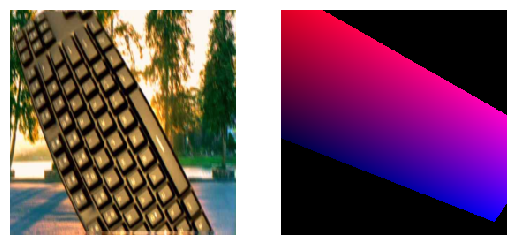

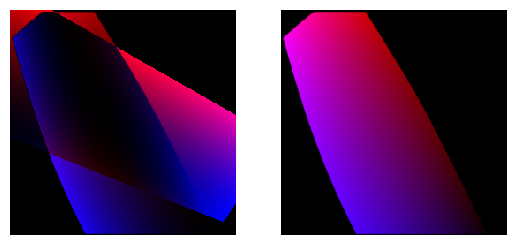

In [302]:
model.to(device)
model.eval(device)

img, mask = valid_dataset.random_img()

pred = model.predict(img)
print(pred.max())

imshow(img, pred)
imshow((mask - pred) ** 2, mask)

In [289]:
from math import radians


def alpha_rotation_matrix(alpha):
    """
    Rx = [[1, 0, 0, 0],
          [0, cos(α), sin(α), 0],
          [0, -sin(α), cos(α), 0],
          [0, 0, 0, 1]]
    """
    cos_alpha = torch.cos(alpha)
    sin_alpha = torch.sin(alpha)

    Rx1 = torch.stack([ones, zeros, zeros, zeros], dim=1)
    Rx2 = torch.stack([zeros, cos_alpha, sin_alpha, zeros], dim=1)
    Rx3 = torch.stack([zeros, -sin_alpha, cos_alpha, zeros], dim=1)
    Rx4 = torch.stack([zeros, zeros, zeros, ones], dim=1)
    return torch.stack([Rx1, Rx2, Rx3, Rx4], dim=1)


def beta_rotation_matrix(beta):
    """
    Ry = [[cos(β), 0, sin(β), 0],
          [0, 1, 0, 0],
          [-sin(β), 0, cos(β), 0],
          [0, 0, 0, 1]]
    """
    cos_beta = torch.cos(beta)
    sin_beta = torch.sin(beta)

    Ry1 = torch.stack([cos_beta, zeros, sin_beta, zeros], dim=1)
    Ry2 = torch.stack([zeros, ones, zeros, zeros], dim=1)
    Ry3 = torch.stack([-sin_beta, zeros, cos_beta, zeros], dim=1)
    Ry4 = torch.stack([zeros, zeros, zeros, ones], dim=1)
    return torch.stack([Ry1, Ry2, Ry3, Ry4], dim=1)


def gamma_rotation_matrix(gamma):
    """
    Rz = [[cos(γ), -sin(γ), 0, 0],
          [sin(γ),  cos(γ), 0, 0],
          [0,  0, 1, 0],
          [0, 0, 0, 1]]
    """
    cos_gamma = torch.cos(gamma)
    sin_gamma = torch.sin(gamma)

    Rz1 = torch.stack([cos_gamma, -sin_gamma, zeros, zeros], dim=1)
    Rz2 = torch.stack([sin_gamma, cos_gamma, zeros, zeros], dim=1)
    Rz3 = torch.stack([zeros, zeros, ones, zeros], dim=1)
    Rz4 = torch.stack([zeros, zeros, zeros, ones], dim=1)
    return torch.stack([Rz1, Rz2, Rz3, Rz4], dim=1)


def rotation_matrix(alpha, beta, gamma):
    """
    R = Rx @ Ry @ Rz
    """
    Rx = alpha_rotation_matrix(alpha)
    Ry = beta_rotation_matrix(beta)
    Rz = gamma_rotation_matrix(gamma)

    return Rz @ Ry @ Rx


def extrinsic_matrix(x, y, z):
    """
    position = [x, y, z]
    
    E = [R | -R @ position]
    E = [[1, 0, 0, 0],
         [0, 1, 0, 0],
         [0, 0, 1, -1]]
                  
    K = [[256, 0, 127.5, -127.5],
         [0, 256, 127.5, -127.5],
         [0, 0, 1, -1]]
    """
    E1 = torch.stack([ones, zeros, zeros, -x], dim=1)
    E2 = torch.stack([zeros, ones, zeros, -y], dim=1)
    E3 = torch.stack([zeros, zeros, ones, -z], dim=1)
    return torch.stack([E1, E2, E3], dim=1)


def intrinsic_matrix(fx, fy, cx, cy):
    """
    K = [[fx, 0, cx],
         [0, fy, cy],
         [0,  0,  1]]
    """
    K1 = torch.stack([fx, zeros, cx], dim=1)
    K2 = torch.stack([zeros, fy, cy], dim=1)
    K3 = torch.stack([zeros, zeros, ones], dim=1)
    return torch.stack([K1, K2, K3], dim=1)


def projection_matrix(x, y, z):
    """
    P = K @ E
    """
    E = extrinsic_matrix(x, y, z)
    return K @ E


def prediction_to_projection_matrix(pred):
    global ones, zeros

    batch_size = len(pred)
    ones = torch.ones(batch_size, dtype=torch.float32, device=device)
    zeros = torch.zeros(batch_size, dtype=torch.float32, device=device)

    x = pred[:, 3] * 0
    y = pred[:, 4] * 0
    z = pred[:, 5] + 4

    return projection_matrix(x, y, z)


def project_point(P, v):
    """
    [x', y', z'] = P @ [x, y, 1]
    return [x' / z', y' / z']
    """
    v = P @ v
    return (v[:, :2] / v[:, -1:]).T


def prediction_to_corners(pred):
    P = prediction_to_projection_matrix(pred)

    alpha = torch.tanh(pred[:, 0])
    beta = torch.tanh(pred[:, 1])
    gamma = torch.tanh(pred[:, 2])

    P = P @ rotation_matrix(alpha, beta, gamma)

    return (project_point(P, P1),
            project_point(P, P2),
            project_point(P, P3),
            project_point(P, P4))


def xy_to_uv_matrix(p1, p2, p3, p4):
    """
    M = [[x1, x2, x3],
         [y1, y2, y3],
         [ 1,  1,  1]]
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    x4, y4 = p4

    M1 = torch.stack([x1, x2, x3], dim=1)
    M2 = torch.stack([y1, y2, y3], dim=1)
    M3 = torch.stack([ones, ones, ones], dim=1)
    M = torch.stack((M1, M2, M3), dim=1)

    M_inv = torch.inverse(M)

    """
    X = [x4, y4, 1]
    """
    X = torch.stack([x4, y4, ones], dim=1)
    X = X.unsqueeze(dim=-1)

    """
    H = M @ X = [λ, μ, τ]
    """
    H = M_inv @ X
    H = H.squeeze(dim=-1)

    """
    A = [[λ * x1, μ * x2, τ * x3],
         [λ * y1, μ * y2, τ * y3],
         [     λ,      μ,     τ]]
    """
    A = torch.einsum('bij, bj -> bij', M, H)
    A_inv = torch.inverse(A)

    """
    C = B @ A_inv
    [x', y', z'] = C @ [x, y, 1]
    result = [x' / z', y' / z']
    
    only keep values between 0 & 255, zero-out the rest
    """
    return B @ A_inv


def prediction_to_texture_coordinates(pred):
    corners = prediction_to_corners(pred)
    C = xy_to_uv_matrix(*corners)

    """
    [u, v, z] = C @ [x, y, 1]
    result = [u / z, y / z]
    """
    result = torch.einsum('bij, yxj -> byxi', C, coordinates)
    result = result[:, :, :, :2] / result[:, :, :, -1:]

    # filter any points outside the keyboard
    result[(result.max(axis=-1)[0] > 255)] = 0
    result[result.min(axis=-1)[0] < 0] = 0

    # reorder dimensions from (batch, y, x, channel) to (batch, channel, y, x)
    result = torch.einsum('byxc -> bcyx', result)
    return (result / 128) - 1


def xy_to_uv_change_of_basis_matrix():
    """
    M = [[x1, x2, x3],
         [y1, y2, y3],
         [ 1,  1,  1]]
         
    X = [x4, y4, 1]
    """
    M = np.array([[0, 255, 255],
                  [0, 0, 255],
                  [1, 1, 1]])
    M_inv = np.linalg.inv(M)

    X = np.array([0, 255, 1])

    """
    H = M @ X = [λ, μ, τ]
    """
    H = M_inv @ X

    """
    B = [[λ * x1, μ * x2, τ * x3],
         [λ * y1, μ * y2, τ * y3],
         [     λ,      μ,     τ]]
    """
    return torch.tensor(M * H, dtype=torch.float32, device=device)


def color_coordinates_mesh():
    x = np.linspace(0, 255, SIZE[0])
    y = np.linspace(0, 255, SIZE[1])
    xx, yy = np.meshgrid(x, y)
    one = np.ones(xx.shape)

    mesh = np.stack((xx, yy, one), axis=-1)
    return torch.tensor(mesh, dtype=torch.float32, device=device)


B = xy_to_uv_change_of_basis_matrix()

K = torch.tensor([[256, 0, 127.5],
                  [0, 256, 127.5],
                  [0, 0, 1]], dtype=torch.float32, device=device)

# K = K @ E

width = 2.928
height = 1

coordinates = color_coordinates_mesh()

P1 = torch.tensor([width, -height, 0, 1], dtype=torch.float32, device=device)
P2 = torch.tensor([width, height, 0, 1], dtype=torch.float32, device=device)
P3 = torch.tensor([-width, height, 0, 1], dtype=torch.float32, device=device)
P4 = torch.tensor([-width, -height, 0, 1], dtype=torch.float32, device=device)

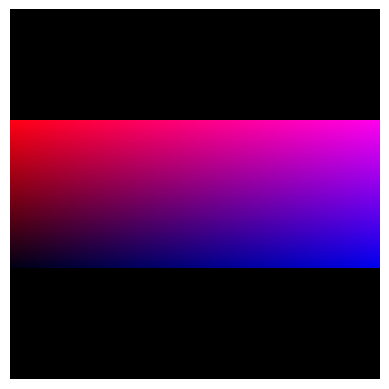

In [248]:
import random

# prediction format: [[alpha, beta, gamma, x, y, z], ... (batches)]
prediction = torch.tensor([[0.0, 0, 0, 0, 0, 5],
                           [0, 0, 0, 0, 0, 4]],
                          requires_grad=True, device=device, dtype=torch.float32)

texcoords = prediction_to_texture_coordinates(prediction)
imshow(texcoords[1])